# Score-Matching Langevin Dynamics

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.distributions.multivariate_normal import MultivariateNormal

## Langevin Dynamics using the true score function

We begin by implementing Langevin Dynamics which has theoretical guarantees as proven in the paper.

In [19]:
SAMPLES = 100
NUM_STEPS = 10000
LR = 0.01

### Implementation 1: 1D Langevin Dynamics Converging to GMM distribution
1D Gaussian mixture model with 0.5 chance being centered around 2 and 0.5 chance being centered around -2.

In [4]:
def langevin_dynamics(score, x, num_steps=NUM_STEPS, step_size=LR):
    """
    Langevin dynamics implemented as shown in Sohl-Dickstein et al. 2015
    """
    for _ in range(num_steps):
        score_x = score(x)
        x = x + 0.5 * step_size * torch.autograd.grad(score_x.sum(), x, create_graph=True)[0]
        x += np.sqrt(step_size) * torch.randn_like(x)
    return x

In [5]:
def mixture_of_gaussians(x):
    """
    Score function for a mixture of two Gaussians, one at -2 and one at 2 with unit variance and equal weights.
    """
    return torch.log(0.5 * torch.exp(-0.5 * (x - 2).pow(2)) + 0.5 * torch.exp(-0.5 * (x + 2).pow(2)))

We start by sampling points uniformly and show what the effect will be when performing Langevin Dynamics on them. Note that in theory we would've needed for the prior to be with the same support as the posterior, but empirically this doesn't seem to be too important.

In [6]:
def visualize_samples(samples):
    plt.hist(samples.detach().numpy(), bins=100, density=True)
    plt.show()

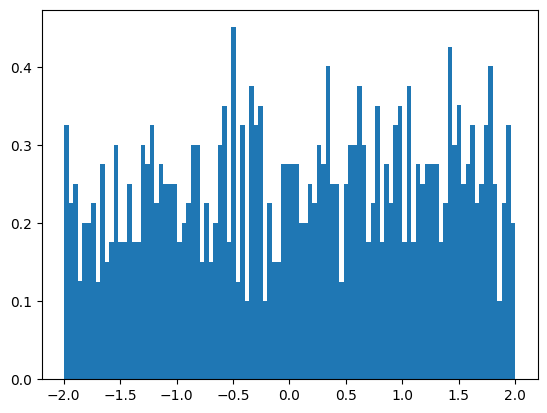

In [7]:
sample = torch.rand(1000, requires_grad=True) * 4 - 2
final = langevin_dynamics(mixture_of_gaussians, sample)
visualize_samples(sample)

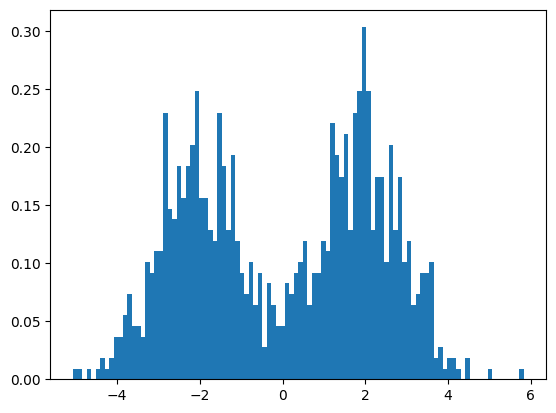

In [8]:
visualize_samples(final)

### Implementation 2: Multivariate Langevin Dynamics
2D multivariate normal, GMM with 0.5 chance of being centered at (-1, -1) and 0.5 of being centered at (1, 1). Both have low variance for them to have essentially disjoint supports.

In [9]:
def mixture_of_gaussians2(x, mu1, mu2, sigma1, sigma2, p1):
    normal1 = MultivariateNormal(mu1, sigma1 * torch.eye(mu1.shape[0]))
    normal2 = MultivariateNormal(mu2, sigma2 * torch.eye(mu2.shape[0]))

    return torch.log(p1 * torch.exp(normal1.log_prob(x)) + (1 - p1) * torch.exp(normal2.log_prob(x)))

In [10]:
sample = torch.randn(1000, 2, requires_grad=True)
mu1, sigma1 = torch.tensor([1., 1.]), 0.1
mu2, sigma2 = torch.tensor([-1., -1.]), 0.1
p1 = 0.5
final = langevin_dynamics(lambda x: mixture_of_gaussians2(x, mu1, mu2, sigma1, sigma2, p1), sample)

In [5]:
def visualize_samples2(samples):
    plt.scatter(samples.detach().numpy()[:, 0], samples.detach().numpy()[:, 1], edgecolors='black', facecolors='none', alpha=0.5, s=1)
    plt.show()

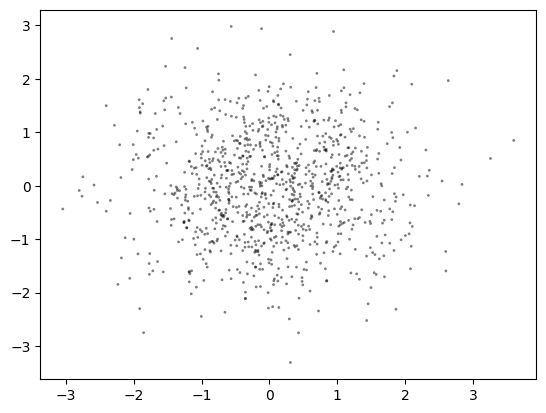

In [12]:
visualize_samples2(sample)

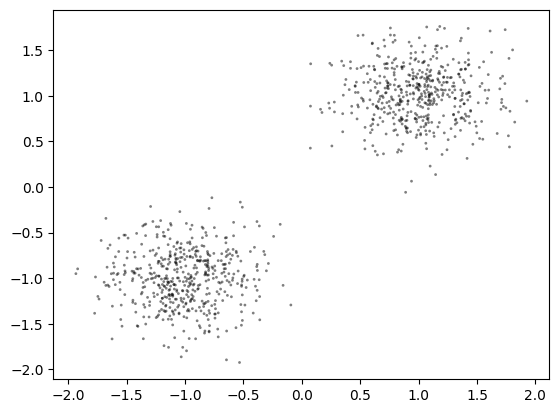

In [13]:
visualize_samples2(final)

### Implementation 3: Imbalanced GMM
What happens when the probability of being in one cluster are higher? This information is supposed to be hard to obtain in the process of taking the gradient.

In [14]:
sample = torch.randn(1000, 2, requires_grad=True)
p1 = 0.1

final = langevin_dynamics(lambda x: mixture_of_gaussians2(x, mu1, mu2, sigma1, sigma2, p1), sample)

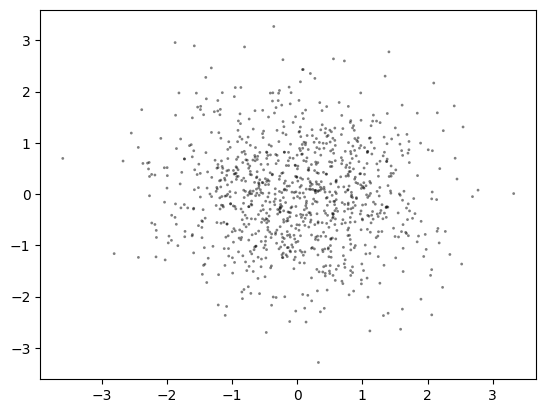

In [15]:
visualize_samples2(sample)

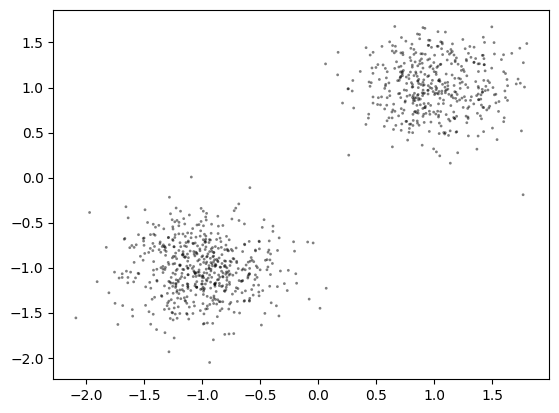

In [16]:
visualize_samples2(final)

It is still equally divided. The distribution is supposed to appear as follows:

In [17]:
true_prob = torch.rand(1000) < p1
true_prob = true_prob.float()

normal1 = MultivariateNormal(mu1, sigma1 * torch.eye(mu1.shape[0]))
normal2 = MultivariateNormal(mu2, sigma2 * torch.eye(mu2.shape[0]))


true_sample = torch.stack([normal1.sample() if p else normal2.sample() for p in true_prob])

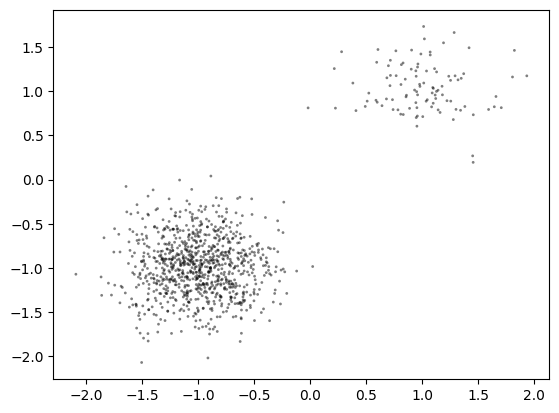

In [18]:
visualize_samples2(true_sample)

### Implementation 4: Noise Conditional Langevin Dynamics
Add decreasing noise to the data until convergence.

In [19]:
def annealed_langevin_dynamics(score, x, sigmas, num_steps=NUM_STEPS, step_size=LR):
    for sigma in sigmas:
        eps = (sigma / sigmas[-1]) ** 2 * step_size if sigma > 0 else step_size
        for _ in range(num_steps):
            score_x = score(x, sigma)
            x = x + 0.5 * eps * torch.autograd.grad(score_x.sum(), x, create_graph=True)[0]
            x += np.sqrt(eps) * torch.randn_like(x)
        plt.scatter(x.detach().numpy()[:, 0], x.detach().numpy()[:, 1], edgecolors='black', facecolors='none', alpha=0.5, s=1)
        plt.title(f"sigma = {sigma}")
        plt.show()
    return x

In [20]:
def mixture_of_gaussians3(x, noise):
    normal1 = MultivariateNormal(mu1, (noise + sigma1) * torch.eye(mu1.shape[0]))
    normal2 = MultivariateNormal(mu2, (noise + sigma2) * torch.eye(mu2.shape[0]))

    return torch.log(p1 * torch.exp(normal1.log_prob(x)) + (1 - p1) * torch.exp(normal2.log_prob(x)))

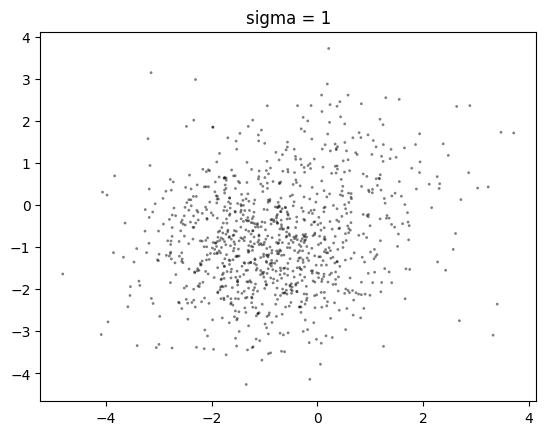

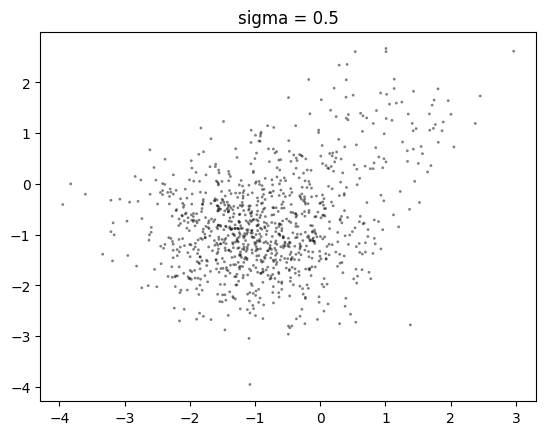

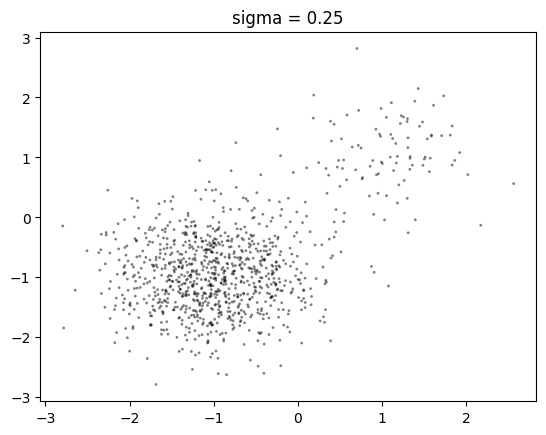

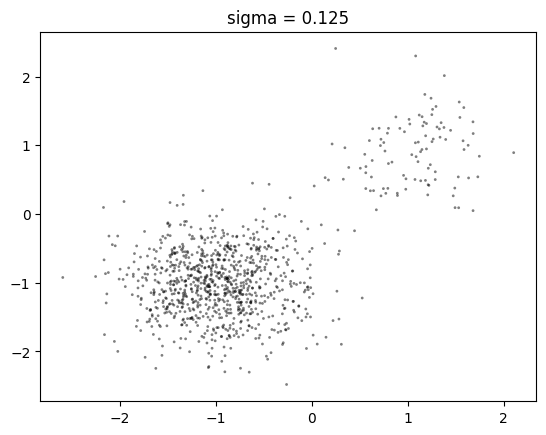

In [21]:
sample = torch.randn(1000, 2, requires_grad=True)
sigmas = [1, 0.5, 0.25, 0.125]
result = annealed_langevin_dynamics(mixture_of_gaussians3, sample, sigmas)

We can see that the annealed Langevin Dynamics do much better at estimating the distribution when it is not "even".

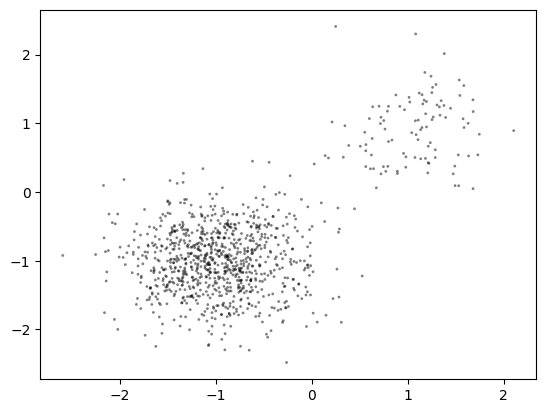

In [22]:
visualize_samples2(result)

## Langevin Dynamics using a score matcher

### Score Matching for multivariate normal

Now, we will implement a score-matching mechanism and use it to run Langevin Dynamics

We will start by implementing regular SMLD on the multivariate Gaussian, then use something more complicated for more complex distributions.

In [29]:
class FullyConnectedScoreMatcher(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FullyConnectedScoreMatcher, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = input_dim

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def langevin_dynamics(self, x, num_steps=NUM_STEPS, step_size=LR):
        for _ in range(num_steps):
            score = self(x)
            x = x + step_size * score + torch.randn_like(x) * np.sqrt(2 * step_size)
        return x
    
    def sample(self, num_samples=1000):
        x = torch.randn(num_samples, self.input_dim)
        return self.langevin_dynamics(x)
    
    

In [30]:
train_X = torch.randn(1000, 2) * torch.sqrt(torch.tensor([0.1])) + torch.tensor([1., 1.], requires_grad=True)

# get the score function of the standard normal distribution
distribution = MultivariateNormal(torch.tensor([1.0,1.0]), 0.1 * torch.eye(2))
score = torch.autograd.grad(distribution.log_prob(train_X).sum(0), train_X)[0]

In [31]:
model = FullyConnectedScoreMatcher(2, 128)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [32]:
for _ in range(1000):
    optimizer.zero_grad()
    score_pred = model(train_X)
    loss = criterion(score_pred, score)
    loss.backward()
    optimizer.step()

In [34]:
samples = model.sample(1000)

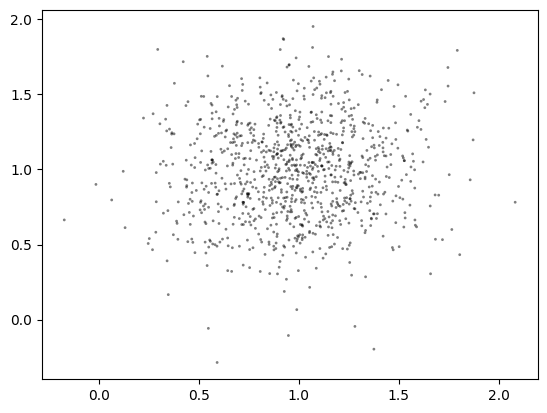

In [35]:
visualize_samples2(samples)

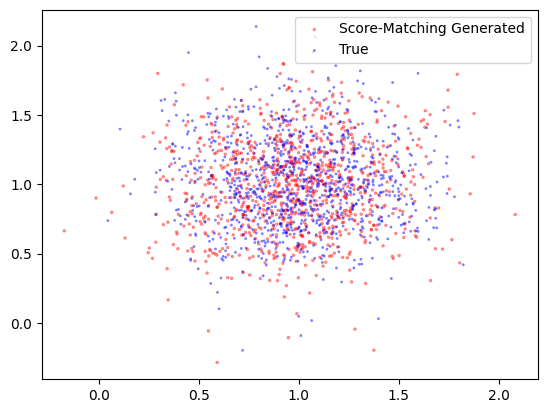

In [44]:
true_sample = distribution.sample((1000,))


plt.scatter(samples.detach().numpy()[:, 0], samples.detach().numpy()[:, 1], edgecolors='red', facecolors='none', alpha=0.5, s=2)
plt.scatter(true_sample[:, 0], true_sample[:, 1], edgecolors='blue', facecolors='none', alpha=0.5, s=1)
plt.legend(["Score-Matching Generated", "True"])
plt.show()

Using relatively small training data (1000 points) we were able to train a score network that can approximate the desired distribution. This is relatively easier using normal (Gaussian) distributions because they are very well-behaved. This is due to the distribution being very smooth. Distributions of images are of course much more complex, with many more variables (784 in MNIST) and much more sharp, unsmooth spikes in the density.

### Score Matching with a Mixture of Gaussians

We want to see how the score matcher will behave in cases where annealed LD might be necessary, such as regions with low density. Note that if the regions are far enough, we can ignore the influence of each region on each other in the score.

In [33]:
probabilities = torch.rand(1000) < 0.1
distribution1 = MultivariateNormal(torch.tensor([1.0,1.0]), 0.01 * torch.eye(2))
distribution2 = MultivariateNormal(torch.tensor([-1.0,-1.0]), 0.01 * torch.eye(2))

# where the probability is true, sample from the first distribution, otherwise sample from the second
score_x = lambda x, dist: torch.autograd.grad(dist.log_prob(x).sum(), x)[0]
X = torch.randn(1000, 2, requires_grad=True)
mu_1 = torch.tensor([1., 1.])
mu_2 = torch.tensor([-1., -1.])
sigma = 0.1

train_X = torch.stack([X[i] * sigma + mu_1 if probabilities[i] else X[i] * sigma + mu_2 for i in range(len(X))])
train_Y = torch.stack([score_x(train_X[i], distribution1) if probabilities[i] else score_x(train_X[i], distribution2) for i in range(len(train_X))])


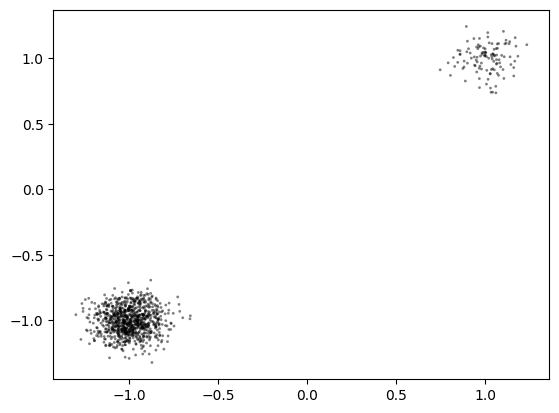

In [34]:
visualize_samples2(train_X)

In [35]:
model = FullyConnectedScoreMatcher(2, 128)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [36]:
for _ in range(1000):
    optimizer.zero_grad()
    score_pred = model(train_X)
    loss = criterion(score_pred, train_Y)
    loss.backward(retain_graph=True)
    optimizer.step()

Problem 1: Unable to learn the weights. I did kind of cheat by taking only the score of the respective marginal distribution instead of taking the score of the entire distribution. However the gradients would be very close to 0 anyway so I wanted to keep it simple.

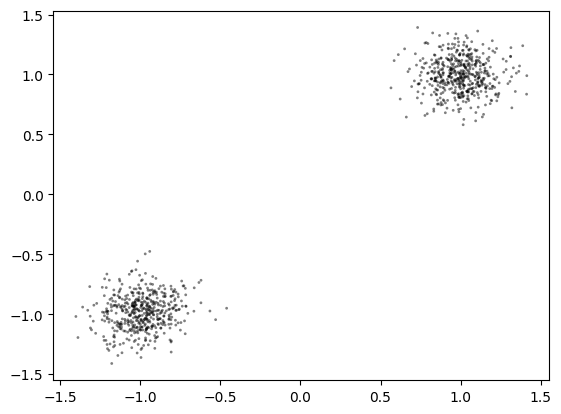

In [40]:
visualize_samples2(model.sample(1000))

Problem 2: We would expect the score at 0 to be exactly 0. However, because the likelihood of sampling 0 in the distribution is very low, it is not represented in the train data. What this means is that the score matcher will be very inaccurate in regions with low density.

In [42]:
model(torch.tensor([0.0,0.0]))

tensor([-0.2522,  2.9460], grad_fn=<ViewBackward0>)

### Score matching for MNIST images.

In this case, we need a more fit architecture, such as the U-Net. Additionally, we need to understand what the exact probability distribution is. This is what annealed LD is good for, because the distribution we have is only the empirical distribution of the train set and adding Gaussian noise to that distribution will be what smoothens the density greatly. We will be using denoising score matching, so as to make the 

UNET implementation based on open source: https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [65]:
class DoubleConv(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(input_dim, hidden_dim, 3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, output_dim, 3, padding=1),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Downscaler(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Downscaler, self).__init__()
        self.downscaler = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(input_dim, input_dim, output_dim)
        )

    def forward(self, x):
        return self.downscaler(x)
    

class Upscaler(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Upscaler, self).__init__()
        self.upscaler = nn.ConvTranspose2d(input_dim, output_dim, 2, stride=2)
        self.conv = DoubleConv(input_dim, input_dim, output_dim)

    def forward(self, x1, x2):
        x1 = self.upscaler(x1)
        # match dimensions of x1 and x2 by adding padding to x1.
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    

class UNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(UNet, self).__init__()
        self.inc = DoubleConv(input_dim + 1, 16, 16)
        self.down1 = Downscaler(16, 32)
        self.down2 = Downscaler(32, 64)
        self.down3 = Downscaler(64, 128)
        self.up1 = Upscaler(128, 64)
        self.up2 = Upscaler(64, 32)
        self.up3 = Upscaler(32, 16)
        self.outc = nn.Conv2d(16 + 1, output_dim, 1)

    def embed_sigma(self, sigma, shape):
        return sigma.view(-1, 1, 1, 1).expand(-1, 1, shape[2], shape[3])

    def forward(self, x, sigma):
        sigma = self.embed_sigma(sigma, x.shape)
        x = torch.cat([x, sigma], dim=1)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        x = torch.cat([x, sigma], dim=1)
        x = self.outc(x)
        return x

In [91]:
class ScoreMatchingUNet(UNet):
    def __init__(self, input_dim, output_dim, device):
        super(ScoreMatchingUNet, self).__init__(input_dim, output_dim)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.device = device

    def annealed_langevin_dynamics(self, x, num_steps, step_size):
        for sigma in torch.logspace(torch.log10(torch.tensor(1.0)), torch.log10(torch.tensor(0.01)), 10).to(device):
            eps = (sigma / 0.01) ** 2 * step_size
            for i in range(num_steps):
                print(f'Step {i}')
                score_x = self(x, sigma)
                x = x + 0.5 * eps * score_x
                x += torch.sqrt(eps) * torch.randn_like(x)
            print(x.detach().cpu().numpy())
        return x.detach().cpu().numpy()

    def sample(self, num_samples=1000, height=28, width=28, num_steps=NUM_STEPS, step_size=LR):
        x = torch.randn(num_samples, self.input_dim, height, width, requires_grad=True).to(device)
        return self.annealed_langevin_dynamics(x, num_steps, step_size)

In [92]:
model = ScoreMatchingUNet(1, 1, device)
model = model.to(device)
sample = model.sample(1, num_steps=500)

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69
Step 70
Step 71
Step 72
Step 73
Step 74
Step 75
Step 76
Step 77
Step 78
Step 79
Step 80
Step 81
Step 82
Step 83
Step 84
Step 85
Step 86
Step 87
Step 88
Step 89
Step 90
Step 91
Step 92
Step 93
Step 94
Step 95
Step 96
Step 97
Step 98
Step 99
Step 100
Step 101
Step 102
Step 103
Step 104
Step 105
Step 106
Step 107
Step 108
Step 109
Step 110
Step 111
Step 112
Step 113
Step 114
Step 115
Step 116
Step 117
Step 118
Step 119
Step 120
Step 121
Step 122
Ste

In [94]:
def denoising_loss(model, target, sigma):
    noise = torch.randn_like(target) * sigma
    noisy_target = target + noise
    score = model(noisy_target, sigma)
    target = -noise / (sigma ** 2)
    return 0.5 * ((score - target) ** 2).sum(dim=(1, 2, 3)).mean(dim=0)

In [95]:
batch = torch.randn(1, 1, 28, 28).to(device)
sigma = torch.tensor(0.1).to(device)
sigma_tensor = torch.full((batch.shape[0], 1, 1, 1), sigma).to(device)

In [ ]:
# use MNIST as train set
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
trainloader = trainloader.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    print(f"Epoch {epoch}")
    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        optimizer.zero_grad()
        loss = 0
        for sigma in torch.logspace(torch.log10(torch.tensor(1.0)), torch.log10(torch.tensor(0.01)), 10).to(device):
            sigma_tensor = torch.full((inputs.shape[0], 1, 1, 1), sigma).to(device)
            loss += denoising_loss(model, inputs, sigma) * (sigma_tensor ** 2)
        loss.backward()
        optimizer.step()

sample = model.sample(1, num_steps=500)

In [99]:
loss = 0
for sigma in torch.logspace(torch.log10(torch.tensor(1.0)), torch.log10(torch.tensor(0.01)), 10).to(device):
    sigma_tensor = torch.full((batch.shape[0], 1, 1, 1), sigma).to(device)
    loss += denoising_loss(model, batch, sigma_tensor) * (sigma ** 2)
loss.backward()

In [ ]:
denoising_loss(model, )